# Introduction

A health tech company called **BeHealthy** aimed to connect the medical communities with millions of patients across the country.\
**BeHealthy** has a web platform that allows doctors to list their services and manage patient interactions and provides services for patients such as booking interactions with doctors and ordering medicine online. Here, doctors can easily organise appointments, track past medical records and provide e-prescriptions.

## Problem Statement

**BeHealthy** require **predictive model** which can **identify disease and treatment** from the patient interaction with doctors or ordering medicine online.

## Observation

- The idea of this task is to extract the **useful information** from text, and in addition to that, the **entity of the useful information** also need to be identified.
- Because the information we are planning to extract from the statement interactions between doctor and patients related to medical terms which are not regular usage day-to-day words.

## Approach

- By observing the requirement, it is clearly visible that we have to process the textual sentence and identify the entities like **Disease and Treatment**.
We can predict these all requirements using
        -  CRF (Conditional Random Field) classifier.
        -  Random Forest Classifier.
        -  HMM (Hidden Markov Model).
        -  Perceptron Model.
        -  SGD Classifier Model.
        -  MultinomialNB Classifier Model.
        -  Passive Aggressive Classifier Model.
        -  Transformers (I am trying to adjust the data to use it with the best results).

#### **Model Explanation**
1. For Medical Entity Recognition, we are building CRF model which uses custom NER because the entities we are planning to recognise all related to medical terminologies.
2. Luckily!! we received dataset which contains sentences along with labels, labels/tags are very important for Entity recognition.
**Note**: *If the dataset is not labelled, you have to manually label the data for Model Building and Prediction*.

#### **Dataset Explanation**
We have four data file for this activity to proceed, they are
1. Train Sentence Dataset
2. Train Label Dataset
3. Test Sentence Dataset
4. Test Label Dataset

Sentence file contains all interactions between patients and doctor, and Label file contains all entity tags for particular words arranged as per sentence.\
We need to do few preprocessing while accessing the dataset we will explore that in further steps

#### **Library Explanation**
1. Pandas - Dataframe, Content storage and processing
2. Regular Expression (re) - Identify the textual pattern
3. SpaCy - NLP, POS tag check
4. Warnings - To avoid warning messages
5. Sklearn, Sklearn_CRFsuite - Model building and Evaluation
6. TQDM - provides a simple and efficient way to display progress bars and loading indicators.
7. Textwrap - wrapping long lines of text into multiple shorter lines with a specified width.

# Import Dependences

In [ ]:
# Download missing packages.
!pip install pycrf
!pip install sklearn-crfsuite
# !pip install -U 'scikit-learn<0.24'
!pip install eli5

In [ ]:
# Libraries Import.
import numpy as np
import math
import pandas as pd
import re
import spacy
from tqdm import tqdm
import textwrap
import eli5
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')

# Import model and metrics
from sklearn_crfsuite import CRF, scorers, metrics

In [ ]:
# Import other classifiers packages.
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, HalvingGridSearchCV
# Ensembles
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier, StackingClassifier
# Classifiers
from sklearn.multiclass import OneVsOneClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron, SGDClassifier, PassiveAggressiveClassifier, LogisticRegression, RidgeClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from importlib.metadata import version
libs = ['scikit-learn', 'pycrf', 'numpy', 'pandas', 'regex', 'spacy', 'tqdm', 'sklearn_crfsuite', 'seaborn', 'matplotlib']
for lib in libs:
  print(f"{lib} ---- {version(lib)}")

scikit-learn ---- 1.2.2
pycrf ---- 0.0.1
numpy ---- 1.23.5
pandas ---- 1.5.3
regex ---- 2023.6.3
spacy ---- 3.6.1
tqdm ---- 4.66.1
sklearn_crfsuite ---- 0.3.6
seaborn ---- 0.12.2
matplotlib ---- 3.7.1


## **Essential functions**

### **Pre-processing Functions**

In [ ]:
# Extract sentence from words
def content_extract(file_path='',sep='\t'):
    '''
    It helps to extract the word based on the separator to form the sentence.
    Args:
      - file_path: a string path that defines the file path.
      - sep: a string type that describes the separation type of the file.
    Returns:
      - A Word based on the separator to form the sentence.
    '''
    try:
      with open (file_path,'r', encoding='utf-8') as text:
        if text.mode == 'r':
          content = text.readlines()
          sentence = []
          final_sentence = ""
          for line in content:
            line_content_word = line.strip('\n')
            if line_content_word == "":
              # Once it get matched with separator, it appends previous extracted concatenated string as sentence
              # final_sentence = re.sub('(?<=[\(]) | (?=[%\',)])','', final_sentence)
              sentence.append(final_sentence.strip(" "))
              #Initialize for next sentence
              final_sentence = ""
            else:
              # Tell the loop identifies the separator it concatenates string
              final_sentence += line_content_word + " "
          print('Total identified value: ', len(sentence),'\n')
          print('Sample display value:\n', sentence[:10])
          return sentence
    except FileNotFoundError:
        print('Check and provide proper file path')

### **Post-processing functions**

In [ ]:
# A class to retrieve the sentences details from the dataframe
class sentencedetail(object):
  def __init__(self, data):
    '''
    Constructor function defines the sentence details.
    Args:
      - self: class essential object.
      - data: dataframe we want to pre-process it.
    Returns:
      - Retrieve the sentences details from the dataframe.
    '''
    self.data = data
    self.empty = False
    agg_func = lambda s: [(word, pos, label) for word, pos, label in zip(s["word"].values.tolist(), s["pos"].values.tolist(),s["label"].values.tolist())]
    self.grouped = self.data.groupby("sentence").apply(agg_func)
    self.sentences = [s for s in self.grouped]

## **Feature Extraction**

In [ ]:
# Feature set
def word2features(word_details, pos):
  '''
  Extract features from sentences.
  Args:
    - sent: A string defines the sentences.
    - i: An integer defines the index of the word in the sentence.
  Returns:
    - Extract features from sentences.
  '''
  # Let's define the features to get the feature value for one word.
  word_details.reset_index(drop=True, inplace=True)
  word = word_details[pos][0]
  postag = word_details[pos][1]

  features = [
      'bias=' + "1.0",
      'word.lower=' + word.lower(),
      'word[-3]=' + word[:-3],
      'word[-2]=' + word[:-2],
      'word.islower=%s' % word.islower(),
      'word.isupper=%s' % word.isupper(),
      'word.istitle=%s' % word.istitle(),
      'word.isdigit=%s' % word.isdigit(),
      'postag=' + postag,
      'postag.isnounpronoun=%s' % (postag in ['NOUN','PROPN']),
  ]

  if (pos > 0):
      prev_word = word_details[pos-1][0]
      prev_postag = word_details[pos-1][1]

      features.extend([
          'prev_word.lower=' + prev_word.lower(),
          'prev_word[-3]=' + prev_word[:-3],
          'prev_word[-2]=' + prev_word[:-2],
          'prev_word.islower=%s' % prev_word.islower(),
          'prev_word.isupper=%s' % prev_word.isupper(),
          'prev_word.istitle=%s' % prev_word.istitle(),
          'prev_word.isdigit=%s' % prev_word.isdigit(),
          'prev_postag=' + prev_postag,
          'prev_postag.isnounpronoun=%s' % (prev_postag in ['NOUN','PROPN']),
      ])
  else:
      features.append('BEG')

  if (pos < len(word_details) - 1):
      next_word = word_details[pos+1][0]
      next_postag = word_details[pos+1][1]

      features.extend([
          'next_word.lower=' + next_word.lower(),
          'next_word[-3]=' + next_word[:-3],
          'next_word[-2]=' + next_word[:-2],
          'next_word.islower=%s' % next_word.islower(),
          'next_word.isupper=%s' % next_word.isupper(),
          'next_word.istitle=%s' % next_word.istitle(),
          'next_word.isdigit=%s' % next_word.isdigit(),
          'next_postag=' + next_postag,
          'next_postag.isnounpronoun=%s' % (next_postag in ['NOUN','PROPN']),
      ])
  else:
      features.append('END')

  return features

In [ ]:
# Write a code to get features for a sentence.
def get_word_details(item):
  return item["word"], item["pos"]

def getFeaturesForOneSentence(sentence_id, frequent_dataframe):
  words_for_features = frequent_dataframe[frequent_dataframe["sentence"] == sentence_id].apply(get_word_details, axis=1)
  return [word2features(words_for_features, pos) for pos in range(len(words_for_features))]

In [ ]:
# Write a code to get the labels for a sentence.
def getLabelsForOneSentence(sentence_id, frequent_dataframe):
  return frequent_dataframe[frequent_dataframe["sentence"] == sentence_id]["label"]

In [ ]:
# Define a function to extract features for a sentence.
def sent2features(sent):
  return [word2features(sent, index) for index in range(len(sent))]

In [ ]:
# Define a function to get the labels for a sentence.
def sent2labels(sent):
  return [label for token, postag, label in sent]

# Task for Approach

- Data Preprocessing (EDA)
- Observation of POS Tag and Repeated word frequencies for feature identification
- Create feature function and extract feature from each sentence
- Prepare input and Target variable for model
- Build CRF model
- Evaluate model using F1-score
- Predict disease and treatment
- Use other types of classifiers.

## EDA

### Pre-processing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line.
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**

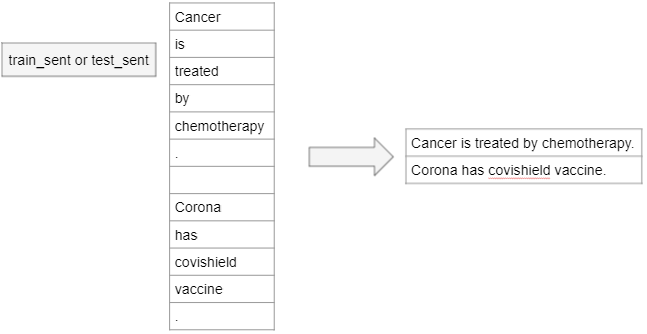

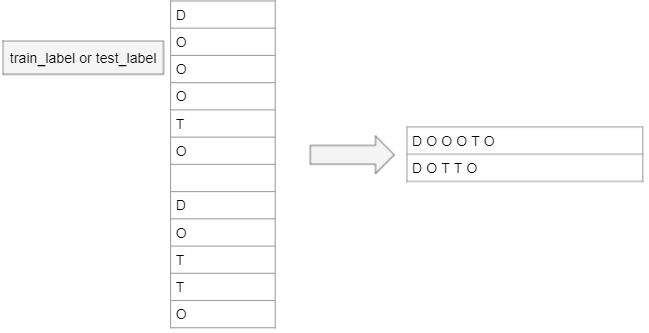

The above dataset is about the labels corresponding to the diseases and the treatment. There are three labels that have been used in this dataset: **O, D and T**, which are corresponding to **Other**, <font color = 'red'>**Disease**</font> and <font color = 'blue'>**Treatment**</font>, respectively.

In [ ]:
# Train sentence extraction from dataset.
train_sents = content_extract(file_path = '/content/train_sent', sep = '\n')

Total identified value:  2599 

Sample display value:
 ['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )', 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )', 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )', "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )", "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )", 'Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age', 'In the third trimester , the amniotic fluid

In [ ]:
# Train label extraction from dataset.
train_labels = content_extract(file_path = '/content/train_label', sep = '\n')

Total identified value:  2599 

Sample display value:
 ['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O']


In [ ]:
# Test sentence extraction from dataset.
test_sents = content_extract(file_path = '/content/test_sent', sep = '\n')

Total identified value:  1056 

Sample display value:
 ['Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )', 'As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration', 'The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period', 'There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )', 'Fluctuations in ambient temperature are inversely correlated to changes in AFI', 'This study tested the hypothesis that to reduce the rate of macrosomic infants in gestational diabetes cases , good glycemic control should be initiated before 34 completed gestational weeks', "In the `` early '' and `` late '

In [ ]:
# Test label extraction from dataset.
test_labels = content_extract(file_path = '/content/test_label', sep = '\n')

Total identified value:  1056 

Sample display value:
 ['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O D D', 'O O O O O O O O O O O O O O O O O O O D D O O O O O O O O']


### Extract POS information using SpaCy

In [ ]:
# Import large spacy library from spacy to find medical related entities but it will take long time.
# !python -m spacy download en_core_web_trf
# !pip install spacy-transformers
# nlp = spacy.load("en_core_web_trf")
# Import small spacy library from spacy to find medical related entities.
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Placeholder of dataframe of (POS tagging, Lemmatization) of word and Label for Train and test sentence.
train_freq_df = pd.DataFrame(columns = ['sentence', 'word', 'lemma', 'pos', 'label'])
test_freq_df = pd.DataFrame(columns = ['sentence', 'word', 'lemma', 'pos', 'label'])

In [ ]:
def get_sent_props(sents, labels, tag = " "):
  '''
  Fit Spacy properties on the sentences.
  Args:
    - sents: A dataframe that we want to extract docs information to.
    - labels: A list that define the sentences labels.
  Returns:
    - Extract features from sentences.
  '''
  sentence = []
  pos = []
  lemma = []
  word = []
  label = []
  sents_counter = 0 # Iteration count
  for sent, sent_label in zip(sents, labels):
    for s, l in zip(sent.split(), sent_label.split()):
      doc = nlp(s)
      for tok in doc:
        sentence.append(tag + str(sents_counter))
        pos.append(tok.pos_)
        lemma.append(tok.lemma_)
        word.append(tok.text)
        label.append(l)
    sents_counter += 1
  return sentence, word, lemma, pos, label

In [ ]:
# Fit get_sent_props func on train data.
train_sentence, train_word, train_lemma, train_pos, train_label = get_sent_props(train_sents, train_labels, tag = "train_sent_")

In [ ]:
# Dataframe for other DL and classic classifiers.
train_freq_df = train_freq_df.append(pd.DataFrame({'sentence':train_sentence, 'word':train_word, 'lemma':train_lemma, 'pos':train_pos, 'label':train_label}))

<ipython-input-21-1c144448de27>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_freq_df = train_freq_df.append(pd.DataFrame({'sentence':train_sentence, 'word':train_word, 'lemma':train_lemma, 'pos':train_pos, 'label':train_label}))


In [ ]:
# Print the first 5 rows of train data.
train_freq_df.head()

,sentence,word,lemma,pos,label
0,train_sent_0,All,all,PRON,O
1,train_sent_0,live,live,VERB,O
2,train_sent_0,births,birth,NOUN,O
3,train_sent_0,>,>,PUNCT,O
4,train_sent_0,or,or,CCONJ,O


In [ ]:
# Fit get_sent_props func on test data.
test_sentence, test_word, test_lemma, test_pos, test_label = get_sent_props(test_sents, test_labels, tag = "test_sent_")
test_freq_df = test_freq_df.append(pd.DataFrame({'sentence':test_sentence, 'word':test_word, 'lemma':test_lemma, 'pos':test_pos, 'label':test_label}))

<ipython-input-23-8cb4dbe8f13b>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_freq_df = test_freq_df.append(pd.DataFrame({'sentence':test_sentence, 'word':test_word, 'lemma':test_lemma, 'pos':test_pos, 'label':test_label}))


In [ ]:
# Print the first 5 rows of test data.
test_freq_df.head()

,sentence,word,lemma,pos,label
0,test_sent_0,Furthermore,furthermore,ADV,O
1,test_sent_0,",",",",PUNCT,O
2,test_sent_0,when,when,SCONJ,O
3,test_sent_0,all,all,PRON,O
4,test_sent_0,deliveries,delivery,NOUN,O


### Check the destribution of Tags

In [ ]:
# View the distribution if the training labels.
train_freq_df.groupby('label').size().reset_index(name='counts')

,label,counts
0,D,3711
1,O,41506
2,T,3107


In [ ]:
# View the distribution if the test labels.
test_freq_df.groupby('label').size().reset_index(name='counts')

,label,counts
0,D,1574
1,O,16853
2,T,1156


### Extract the frequencies of words for POS tag as NOUN & PROPN

In [ ]:
# Extract words and its frequencies which contain NOUN or PROPN as POS tagging.
freq_df = pd.DataFrame()
freq_df = pd.concat((train_freq_df, test_freq_df),axis=0)

In [ ]:
# Print the first 5 rows.
freq_df.head()

,sentence,word,lemma,pos,label
0,train_sent_0,All,all,PRON,O
1,train_sent_0,live,live,VERB,O
2,train_sent_0,births,birth,NOUN,O
3,train_sent_0,>,>,PUNCT,O
4,train_sent_0,or,or,CCONJ,O


In [ ]:
# Group the labels of freq dataframe depending on its count.
freq_df.groupby('label').size().reset_index(name='counts')

,label,counts
0,D,5285
1,O,58359
2,T,4263


### Check null values

In [ ]:
# Check if there are any null values.
freq_df.isnull().sum()

sentence    0
word        0
lemma       0
pos         0
label       0
dtype: int64

In [ ]:
# Resetting index.
freq_df.reset_index(inplace=True, drop=True)

In [ ]:
# Top 25 frequency values for Train and Test that it's a related dataset words.
freq_df[(freq_df['pos'] == 'NOUN') | ((freq_df['pos'] == 'PROPN'))]['word'].value_counts()[:25]

patients        492
treatment       281
cancer          200
therapy         175
disease         143
cell            140
lung            116
group            94
gene             88
chemotherapy     88
effects          85
results          79
women            77
patient          75
TO_SEE           75
surgery          71
risk             71
cases            71
analysis         70
human            67
rate             67
response         66
survival         65
children         64
effect           64
Name: word, dtype: int64

In [ ]:
# Top 25 most frequency values for Train and Test related lemma words.
freq_df[(freq_df['pos'] == 'NOUN') | ((freq_df['pos'] == 'PROPN'))]['lemma'].value_counts()[:25]

patient         587
treatment       316
cancer          226
cell            203
therapy         182
disease         172
effect          163
case            132
group           128
lung            120
result          118
gene            112
year            105
rate            102
trial            91
chemotherapy     91
woman            89
analysis         86
protein          82
response         81
risk             78
child            78
human            77
TO_SEE           75
mutation         75
Name: lemma, dtype: int64

### Dataframe (Sentence, word, POS) visualisation

In [ ]:
# Print the first 5 rows of the train set.
train_freq_df.head(5)

,sentence,word,lemma,pos,label
0,train_sent_0,All,all,PRON,O
1,train_sent_0,live,live,VERB,O
2,train_sent_0,births,birth,NOUN,O
3,train_sent_0,>,>,PUNCT,O
4,train_sent_0,or,or,CCONJ,O


In [ ]:
# Print the first 5 rows of the test set.
test_freq_df.head(5)

,sentence,word,lemma,pos,label
0,test_sent_0,Furthermore,furthermore,ADV,O
1,test_sent_0,",",",",PUNCT,O
2,test_sent_0,when,when,SCONJ,O
3,test_sent_0,all,all,PRON,O
4,test_sent_0,deliveries,delivery,NOUN,O


### Sentense-wise detail dataframe preparation

In [ ]:
# Fetch detail view of sentence for the train set.
train_sent_obj = sentencedetail(train_freq_df)
train_sent_detail = train_sent_obj.sentences

In [ ]:
# Display one sentence detail view for the train set.
train_sent_detail[0]

[('All', 'PRON', 'O'),
 ('live', 'VERB', 'O'),
 ('births', 'NOUN', 'O'),
 ('>', 'PUNCT', 'O'),
 ('or', 'CCONJ', 'O'),
 ('=', 'VERB', 'O'),
 ('23', 'NUM', 'O'),
 ('weeks', 'NOUN', 'O'),
 ('at', 'ADP', 'O'),
 ('the', 'PRON', 'O'),
 ('University', 'NOUN', 'O'),
 ('of', 'ADP', 'O'),
 ('Vermont', 'PROPN', 'O'),
 ('in', 'ADP', 'O'),
 ('1995', 'NUM', 'O'),
 ('(', 'PUNCT', 'O'),
 ('n', 'CCONJ', 'O'),
 ('=', 'VERB', 'O'),
 ('2395', 'NUM', 'O'),
 (')', 'PUNCT', 'O'),
 ('were', 'AUX', 'O'),
 ('retrospectively', 'ADV', 'O'),
 ('analyzed', 'VERB', 'O'),
 ('for', 'ADP', 'O'),
 ('delivery', 'NOUN', 'O'),
 ('route', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('indication', 'NOUN', 'O'),
 ('for', 'ADP', 'O'),
 ('cesarean', 'VERB', 'O'),
 (',', 'PUNCT', 'O'),
 ('gestational', 'ADJ', 'O'),
 ('age', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('parity', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('and', 'CCONJ', 'O'),
 ('practice', 'VERB', 'O'),
 ('group', 'NOUN', 'O'),
 ('(', 'PUNCT', 'O'),
 ('to', 'PART', 'O'),
 ('reflect

In [ ]:
# Fetch detail view of sentence for the train set.
test_sent_obj = sentencedetail(test_freq_df)
test_sent_detail = test_sent_obj.sentences

In [ ]:
# Display one sentence detail view for the train set.
test_sent_detail[0]

[('Furthermore', 'ADV', 'O'),
 (',', 'PUNCT', 'O'),
 ('when', 'SCONJ', 'O'),
 ('all', 'PRON', 'O'),
 ('deliveries', 'NOUN', 'O'),
 ('were', 'AUX', 'O'),
 ('analyzed', 'VERB', 'O'),
 (',', 'PUNCT', 'O'),
 ('regardless', 'ADV', 'O'),
 ('of', 'ADP', 'O'),
 ('risk', 'NOUN', 'O'),
 ('status', 'NOUN', 'O'),
 ('but', 'CCONJ', 'O'),
 ('limited', 'VERB', 'O'),
 ('to', 'PART', 'O'),
 ('gestational', 'ADJ', 'O'),
 ('age', 'NOUN', 'O'),
 ('>', 'PUNCT', 'O'),
 ('or', 'CCONJ', 'O'),
 ('=', 'VERB', 'O'),
 ('36', 'NUM', 'O'),
 ('weeks', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('the', 'PRON', 'O'),
 ('rates', 'NOUN', 'O'),
 ('did', 'VERB', 'O'),
 ('not', 'PART', 'O'),
 ('change', 'VERB', 'O'),
 ('(', 'PUNCT', 'O'),
 ('12.6', 'NUM', 'O'),
 ('%', 'INTJ', 'O'),
 (',', 'PUNCT', 'O'),
 ('280', 'NUM', 'O'),
 ('of', 'ADP', 'O'),
 ('2214', 'NUM', 'O'),
 (';', 'PUNCT', 'O'),
 ('primary', 'NOUN', 'O'),
 ('9.2', 'NUM', 'O'),
 ('%', 'INTJ', 'O'),
 (',', 'PUNCT', 'O'),
 ('183', 'NUM', 'O'),
 ('of', 'ADP', 'O'),
 ('199

In [ ]:
# Get feature details to prepare it for the model with an example of the first sentence.
features = getFeaturesForOneSentence("train_1", freq_df)
prefix = "01 Sentence : "
wrapper = textwrap.TextWrapper(initial_indent = prefix, width = 150, subsequent_indent = ' '*len(prefix))
print(wrapper.fill(train_sents[0]))
print('\n')

i = 1
for feature in features:
    prefix = str('%02d' % i) + " Word     : "
    wrapper = textwrap.TextWrapper(initial_indent = prefix, width = 150, subsequent_indent = ' '*len(prefix))
    print(wrapper.fill(str(feature)))
    i += 1

01 Sentence : All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route ,
              indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )




In [ ]:
# Get feature details label of  to prepare it for the model with an example of the first sentence.
labels = getLabelsForOneSentence("train_sent_1", freq_df)

prefix = "01 Labels  : "
wrapper = textwrap.TextWrapper(initial_indent = prefix, width = 150, subsequent_indent = ' '*len(prefix))
print(wrapper.fill(" ".join(labels)))

01 Labels  : O O O O O O O O O O O O O O O O O O O O O O O O O


# Modelling

## Classical Models

In [ ]:
def cross_val(algorithm_name, vectorizer_name, model, X= None, y= None, scoring= 'f1_macro', cv= 5):
  '''
  Prints the evaluation values.
  Args:
  algorithm_name-- str type represents the name.
  vectorizer_name-- str type represents the vectorizer name.
  model-- the model we want to evaluate by.
  X-- training data.
  Y-- labeled data.
  scoring-- scoring metric.
  cv-- int describe the number of kfolds.
  Returns:
  The evaluation metric of the model.
  '''
  # create an instance of the model in cross_val_score and initialize it.
  model_cross_val= cross_val_score(estimator= model,
                            X= X, y= y,
                            scoring= scoring, cv= cv)
  # display the basic results of cross validation step
  print('''
  {algorithm_name} Classification with {vectorizer_name} Vectorizer Cross Validation Mean Result is: {mean}\n\
  {algorithm_name} Classification with {vectorizer_name} Vectorizer Cross Validation Standard Deviation Result is: {std}\n\
  {algorithm_name} Classification with {vectorizer_name} Vectorizer Cross Validation Score Result is:\n{score}'''.format(algorithm_name= algorithm_name, vectorizer_name= vectorizer_name, mean= model_cross_val.mean(), std= model_cross_val.std(), score= model_cross_val))

### Preprocess Data

#### Input and Target Variable

In [ ]:
print("Training Sentences")
print("------------------")
X_train = [getFeaturesForOneSentence('train_sent_'+str(i), freq_df) for i in tqdm(range(len(train_sents)))]

print("\n")
print("Testing Sentences")
print("------------------")
X_test = [getFeaturesForOneSentence('test_sent_'+str(i), freq_df) for i in tqdm(range(len(test_sents)))]

Training Sentences
------------------


100%|██████████| 2599/2599 [00:30<00:00, 85.05it/s] 




Testing Sentences
------------------


100%|██████████| 1056/1056 [00:13<00:00, 79.60it/s]


In [ ]:
# Prepare y-train and y-test by extracting labels from train and test dataset.
print("Training Labels")
print("------------------")
Y_train = [getLabelsForOneSentence('train_sent_'+str(i), freq_df) for i in tqdm(range(len(train_labels)))]

print("\n")
print("Testing Labels")
print("------------------")
Y_test = [getLabelsForOneSentence('test_sent_'+str(i), freq_df) for i in tqdm(range(len(test_labels)))]

Training Labels
------------------


100%|██████████| 2599/2599 [00:28<00:00, 92.27it/s]




Testing Labels
------------------


100%|██████████| 1056/1056 [00:11<00:00, 91.10it/s] 


### Bulding CRF Model

In [ ]:
# Build the CRF model.
crf = CRF(c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True)
try:
  # fit the model
  crf.fit(X_train, Y_train)
except AttributeError:
  pass

### Evaluating and Predicting values

#### Evaluate model (F1-score)

In [ ]:
# Calculate the f1 score using the test data.
crf_Y_pred = crf.predict(X_test)
f1_score = metrics.flat_f1_score(Y_test, crf_Y_pred, average='weighted')
print('Predicted F1-score for Medical Entity Dataset is: {0} % '.format(round(f1_score*100, 2)))

Predicted F1-score for Medical Entity Dataset is: 92.07 % 


#### Predict Disease and Treatment

In [ ]:
# Taken out predicted label from the model.
def get_labels_as_array(labels):
    pred_label = []

    for label in labels:
        pred_label.extend(label)

    return pred_label

In [ ]:
# Loaded into test dataframe.
test_freq_df['label_predicted_crf'] = get_labels_as_array(crf_Y_pred)

In [ ]:
# Visualise top 5 data.
test_freq_df.head(5)

,sentence,word,lemma,pos,label,label_predicted_crf
0,test_sent_0,Furthermore,furthermore,ADV,O,O
1,test_sent_0,",",",",PUNCT,O,O
2,test_sent_0,when,when,SCONJ,O,O
3,test_sent_0,all,all,PRON,O,O
4,test_sent_0,deliveries,delivery,NOUN,O,O


### Dictionary Preparation

#### Identifying Diseases and Treatments using Custom NER



### Create the logic

We will get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.

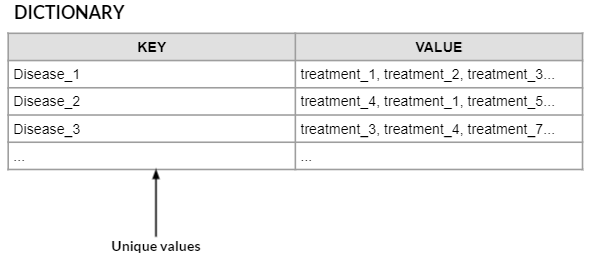

In [ ]:
def dict_prep(freq_df, label_predicted_classifier):
  '''
  Preparing dictionary by keeping Disease as unique Key element and Treatment as value element.
  Args:
    - freq_df: The test dataframe that we want to extract information from the model prediction.
    - label_predicted_classifier: Define the name of the column which is related to the model predictions.
  Returns:
    - Extract data from sentences and the prediction of it (disease, treatment, sentence, med_dict).
  '''
  pred_df = freq_df[(freq_df[label_predicted_classifier] != 'O')]
  pred_df.set_index('sentence',inplace=True)
  disease = []
  treatment = []
  sentence = []
  med_dict = {}
  for index in pred_df.index.unique():
    try:
      val = pred_df.loc[index, label_predicted_classifier].unique()
      if len(val) == 2:
        disease_val = pred_df[pred_df[label_predicted_classifier] == 'D'].loc[index, 'word']
        treatment_val = pred_df[pred_df[label_predicted_classifier] == 'T'].loc[index, 'word']
        disease_single = disease_val if type(disease_val) == str else " ".join(disease_val)
        treatment_single = treatment_val if type(treatment_val) == str else " ".join(treatment_val)
        disease.append(disease_single)
        if disease_single is not None:
          med_dict[disease_single] = treatment_single
        else:
          print('Entered')
          med_dict[disease_single] = f"{med_dict.get(disease_single)}+ '/' + {treatment_single}"
    except AttributeError:
        pass
  return disease, treatment, sentence, med_dict

In [ ]:
# Prepare freq dataframe dict to extract diseases and treatments.
crf_disease, crf_treatment, crf_sentence, crf_med_dict = dict_prep(test_freq_df, 'label_predicted_crf')

### Predict Single Value

In [ ]:
input_sent = 'Alex suffers from Bone marrow cancer'

In [ ]:
# Predicting values of user typing to extract entities and tested it to results treatments.
disease = ''
treatment = ''

input_text = []
input_pos = []
input_label = []

input_sent = input_sent

input_model = nlp(input_sent)

for word in input_model:
    input_text.append(word.text)
    input_pos.append(word.pos_)
    input_label.append('D')

details_sent = pd.DataFrame({'word':input_text, 'pos':input_pos,'label':input_label})
words_for_features = details_sent.apply(get_word_details, axis=1)

test_sent = []

for i in range(len(input_sent.split())):
    test_sent.append(word2features(words_for_features, i))

for i,tag in enumerate(crf.predict([test_sent])[0]):

    if tag == 'D':
        tr = input_sent.split()[i]
        disease += tr + " "

        if tr in crf_med_dict:
          treatment += crf_med_dict.get(tr) + ", "

        if disease.strip() in crf_med_dict:
          treatment += crf_med_dict.get(disease.strip()) + ", "

disease = disease.strip()

if len(treatment) == 0:
    treatment = 'Not Available'
else:
    treatment = treatment.rstrip(", ")

print('Identified Disease   :', disease)
print('Identified Treatment :', treatment)

Identified Disease   : Bone marrow cancer
Identified Treatment : Matrix metalloproteinase inhibitors


### Model weight Visulisation using eli5

In [ ]:
# Show top 30 weights of model across all labels.
try:
  eli5.show_weights(crf, top=30)
except AttributeError:
  pass

### Perceptron Model

In [ ]:
def predicted_value(user_input_sent, model_object, med_dict):
  '''
  Predicting values of user typing to extract entities and tested it to results treatments.
  Args:
    - user_input_sent: A string indicated patient disease.
    - model_object: An object that reference an instance of model classifier.
    - med_dict: dictionary of model prediction that contains disease and its tratments
  Returns:
    - Predicted the type of sentences (extract entities) and its treatments.
  '''
  disease = ''
  treatment = ''

  input_text = []
  input_pos = []
  input_name = []
  input_lemma = []
  input_sent = user_input_sent

  input_model = nlp(input_sent)

  for word in input_model:
    input_name.append("test_sent_0")
    input_text.append(word.text)
    input_pos.append(word.pos_)
    input_lemma.append(word.lemma_)

  details_sent = pd.DataFrame({'sentence': input_name, 'word':input_text, 'lemma': input_lemma, 'pos':input_pos})

  test_sent = dict_vec_obj.transform(details_sent.to_dict('records'))

  for i,tag in enumerate(model_object.predict(test_sent)):

      if tag == 'D':
          tr = input_sent.split()[i]
          disease += tr + " "

          if tr in med_dict:
            treatment += med_dict.get(tr) + ", "

          if disease.strip() in med_dict:
            treatment += med_dict.get(disease.strip()) + ", "

  disease = disease.strip()

  if len(treatment) == 0:
      treatment = 'Not Available'
  else:
      treatment = treatment.rstrip(", ")

  print('Identified Disease   :', disease)
  print('Identified Treatment :', treatment)

In [ ]:
dict_vec_obj = DictVectorizer(sparse=True)
train_data_tp = train_freq_df.drop('label', axis=1)
train_data = dict_vec_obj.fit_transform(train_data_tp.to_dict('records'))
train_labels = train_freq_df.label
classes = np.unique(train_freq_df.label)
print(f"The dataset classes are: {classes}")
print(f"Train data shape is: {train_data.shape}, and Train labels shape are: {train_labels.shape}")

The dataset classes are: ['D' 'O' 'T']
Train data shape is: (48324, 18697), and Train labels shape are: (48324,)


In [ ]:
test_data_tp = test_freq_df.drop('label', axis=1)
test_data = dict_vec_obj.transform(test_data_tp.to_dict('records'))
test_labels = test_freq_df.label
test_data.shape, test_labels.shape

((19583, 18697), (19583,))

In [ ]:
per = Perceptron(verbose=10, n_jobs=-1, max_iter=5)
per.partial_fit(train_data, train_labels, classes)

-- Epoch 1
-- Epoch 1
Norm: 81.88, NNZs: 4846, Bias: -0.300000, T: 48324, Avg. loss: 0.096422Norm: 98.84, NNZs: 6489, Bias: 0.320000, T: 48324, Avg. loss: 0.149825
Total training time: 0.02 seconds.
-- Epoch 1

Total training time: 0.03 seconds.
Norm: 75.63, NNZs: 4105, Bias: -0.290000, T: 48324, Avg. loss: 0.091465
Total training time: 0.01 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Perceptron(max_iter=5, n_jobs=-1, verbose=10)

In [ ]:
print(classification_report(y_pred= per.predict(test_data), y_true= test_labels, labels= classes))

              precision    recall  f1-score   support

           D       0.42      0.50      0.46      1574
           O       0.91      0.94      0.93     16853
           T       0.65      0.25      0.36      1156

    accuracy                           0.86     19583
   macro avg       0.66      0.56      0.58     19583
weighted avg       0.86      0.86      0.85     19583



#### Predict Single Value

In [ ]:
# Loaded into test dataframe.
test_freq_df['label_predicted_per'] = get_labels_as_array(per.predict(test_data))

In [ ]:
per_disease, per_treatment, per_sentence, per_med_dict = dict_prep(test_freq_df, 'label_predicted_per')

In [ ]:
predicted_value(input_sent, per, per_med_dict)

Identified Disease   : Alex Bone cancer
Identified Treatment : inhibitors


### SGD Model

In [ ]:
sgd = SGDClassifier()
sgd.partial_fit(train_data, train_labels, classes)

SGDClassifier()

In [ ]:
print(classification_report(y_pred= sgd.predict(test_data), y_true= test_labels, labels= classes))

              precision    recall  f1-score   support

           D       0.75      0.37      0.49      1574
           O       0.90      0.99      0.94     16853
           T       0.75      0.18      0.29      1156

    accuracy                           0.89     19583
   macro avg       0.80      0.51      0.57     19583
weighted avg       0.88      0.89      0.86     19583



In [ ]:
# Evaluation using cross validation.
cross_val('SGD Classifier', 'Dict', sgd, X= train_data, y= train_labels, scoring= 'f1_weighted', cv= 5)


  SGD Classifier Classification with Dict Vectorizer Cross Validation Mean Result is: 0.8243578351776734
  SGD Classifier Classification with Dict Vectorizer Cross Validation Standard Deviation Result is: 0.03258199492171657
  SGD Classifier Classification with Dict Vectorizer Cross Validation Score Result is:
[0.84617591 0.84550332 0.84725228 0.82051472 0.76234294]


#### Predict Single Value

In [ ]:
# Loaded into test dataframe.
test_freq_df['label_predicted_sgd'] = get_labels_as_array(sgd.predict(test_data))

In [ ]:
sgd_disease, sgd_treatment, sgd_sentence, sgd_med_dict = dict_prep(test_freq_df, 'label_predicted_sgd')

In [ ]:
predicted_value(input_sent, sgd, sgd_med_dict)

Identified Disease   : cancer
Identified Treatment : chemotherapy, chemotherapy


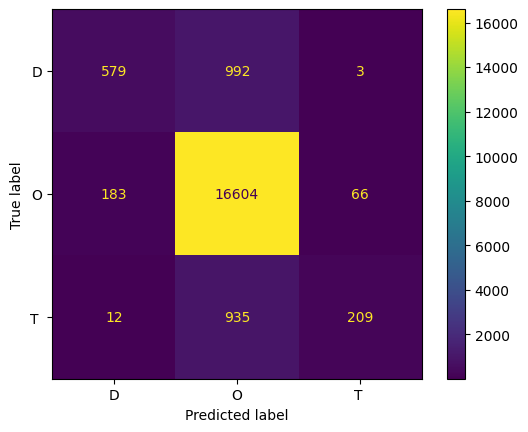

In [ ]:
confusion_matrix_ = confusion_matrix(test_labels, sgd.predict(test_data))
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_, display_labels = ['D', 'O', 'T '])
cm_display.plot()
plt.show()

### MultinomialNB Classifier

In [ ]:
nb = MultinomialNB(alpha=0.01)
nb.partial_fit(train_data, train_labels, classes)

MultinomialNB(alpha=0.01)

In [ ]:
print(classification_report(y_pred= nb.predict(test_data), y_true= test_labels, labels = classes))

              precision    recall  f1-score   support

           D       0.61      0.62      0.61      1574
           O       0.93      0.93      0.93     16853
           T       0.50      0.49      0.50      1156

    accuracy                           0.88     19583
   macro avg       0.68      0.68      0.68     19583
weighted avg       0.88      0.88      0.88     19583



In [ ]:
# Evaluation using cross validation.
cross_val('MultinomialNB', 'Dict', nb, X= train_data, y= train_labels, scoring= 'f1_weighted', cv= 5)


  MultinomialNB Classification with Dict Vectorizer Cross Validation Mean Result is: 0.6548719182026053
  MultinomialNB Classification with Dict Vectorizer Cross Validation Standard Deviation Result is: 0.05515346310652423
  MultinomialNB Classification with Dict Vectorizer Cross Validation Score Result is:
[0.73614684 0.67109288 0.68051204 0.60045016 0.58615767]


#### Predict Single Value

In [ ]:
# Loaded into test dataframe.
test_freq_df['label_predicted_nb'] = get_labels_as_array(nb.predict(test_data))

In [ ]:
nb_disease, nb_treatment, nb_sentence, nb_med_dict = dict_prep(test_freq_df, 'label_predicted_nb')

In [ ]:
predicted_value(input_sent, nb, nb_med_dict)

Identified Disease   : marrow cancer
Identified Treatment : colony stimulating G CSF, colony stimulating G CSF, metalloproteinase inhibitors treatment


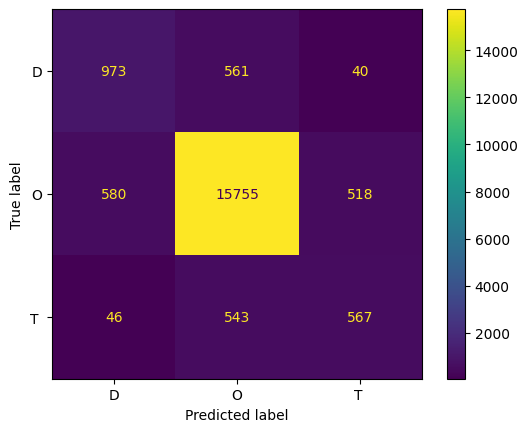

In [ ]:
confusion_matrix_ = confusion_matrix(test_labels, nb.predict(test_data))
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_, display_labels = ['D', 'O', 'T '])
cm_display.plot()
plt.show()

### Passive Aggressive Classifier

In [ ]:
pa =PassiveAggressiveClassifier()
pa.partial_fit(train_data, train_labels, classes)

PassiveAggressiveClassifier()

In [ ]:
print(classification_report(y_pred= pa.predict(test_data), y_true= test_labels, labels= classes))

              precision    recall  f1-score   support

           D       0.75      0.37      0.49      1574
           O       0.90      0.98      0.94     16853
           T       0.67      0.24      0.35      1156

    accuracy                           0.89     19583
   macro avg       0.77      0.53      0.59     19583
weighted avg       0.87      0.89      0.87     19583



In [ ]:
# Evaluation using cross validation.
cross_val('Passive Aggressive', 'Dict', pa, X= train_data, y= train_labels, scoring= 'f1_weighted', cv= 5)


  Passive Aggressive Classification with Dict Vectorizer Cross Validation Mean Result is: 0.7598950922873978
  Passive Aggressive Classification with Dict Vectorizer Cross Validation Standard Deviation Result is: 0.076729176789563
  Passive Aggressive Classification with Dict Vectorizer Cross Validation Score Result is:
[0.8359811  0.78897335 0.80926188 0.74753412 0.617725  ]


#### Predict Single Value

In [ ]:
# Loaded into test dataframe.
test_freq_df['label_predicted_pa'] = get_labels_as_array(pa.predict(test_data))

In [ ]:
pa_disease, pa_treatment, pa_sentence, pa_med_dict = dict_prep(test_freq_df, 'label_predicted_pa')

In [ ]:
predicted_value(input_sent, pa, pa_med_dict)

Identified Disease   : cancer
Identified Treatment : chemotherapy, chemotherapy


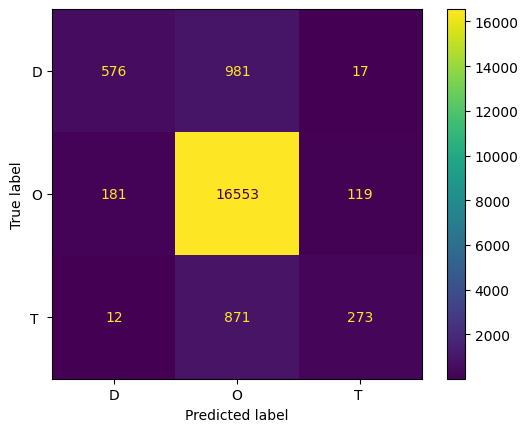

In [ ]:
confusion_matrix_ = confusion_matrix(test_labels, pa.predict(test_data))
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_, display_labels = ['D', 'O', 'T '])
cm_display.plot()
plt.show()

### KNN Classifier

In [ ]:
# Create an object the of KNN Classifier.
knn_obj = OneVsOneClassifier(KNeighborsClassifier(n_neighbors= 5))

In [ ]:
knn_obj.fit(train_data, train_labels)

OneVsOneClassifier(estimator=KNeighborsClassifier())

In [ ]:
print(classification_report(y_pred= knn_obj.predict(test_data), y_true= test_labels, labels = classes))

              precision    recall  f1-score   support

           D       0.76      0.33      0.46      1574
           O       0.90      0.98      0.94     16853
           T       0.64      0.20      0.31      1156

    accuracy                           0.89     19583
   macro avg       0.77      0.51      0.57     19583
weighted avg       0.87      0.89      0.86     19583



In [ ]:
# Evaluation using cross validation.
cross_val('KNeighbors', 'Dict', RandomForestClassifier(n_estimators= 100, max_depth= 5, random_state= 42), X= train_data, y= train_labels, scoring= 'f1_weighted', cv= 5)


  KNeighbors Classification with Dict Vectorizer Cross Validation Mean Result is: 0.7937202947656764
  KNeighbors Classification with Dict Vectorizer Cross Validation Standard Deviation Result is: 6.727921155171731e-05
  KNeighbors Classification with Dict Vectorizer Cross Validation Score Result is:
[0.79381267 0.79366562 0.79366562 0.79366562 0.79379193]


#### Predict Single Value

In [ ]:
# Loaded into test dataframe.
test_freq_df['label_predicted_knn'] = get_labels_as_array(knn_obj.predict(test_data))

In [ ]:
knn_disease, knn_treatment, knn_sentence, knn_med_dict = dict_prep(test_freq_df, 'label_predicted_knn')

In [ ]:
predicted_value(input_sent, knn_obj, knn_med_dict)

Identified Disease   : cancer
Identified Treatment : chemotherapy, chemotherapy


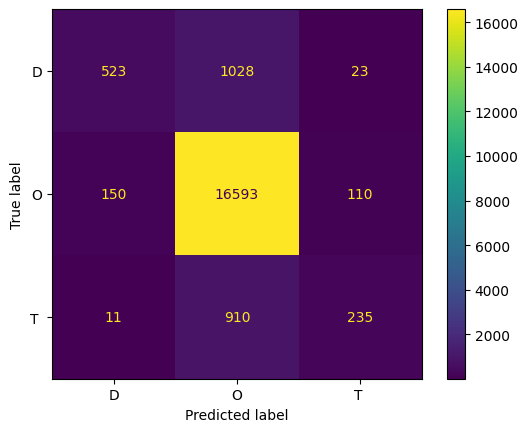

In [ ]:
confusion_matrix_ = confusion_matrix(test_labels, knn_obj.predict(test_data))
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_, display_labels = ['D', 'O', 'T '])
cm_display.plot()
plt.show()

### SVC Classifier

In [ ]:
# Define the class weights
class_weights = {'D': 7.679, 'O': 85.891, 'T': 6.429}

In [ ]:
# Create an object the of SVC Classifier.
svc_obj = SVC(kernel='rbf', class_weight=class_weights, probability=True, decision_function_shape= 'ovr')

In [ ]:
svc_obj.fit(train_data, train_labels)

SVC(class_weight={'D': 7.679, 'O': 85.891, 'T': 6.429}, probability=True)

In [ ]:
print(classification_report(y_pred= svc_obj.predict(test_data), y_true= test_labels, labels = classes))

              precision    recall  f1-score   support

           D       0.58      0.60      0.59      1574
           O       0.93      0.95      0.94     16853
           T       0.68      0.36      0.47      1156

    accuracy                           0.89     19583
   macro avg       0.73      0.64      0.67     19583
weighted avg       0.88      0.89      0.88     19583



In [ ]:
# Evaluation using cross validation.
cross_val('SVC', 'Dict', SVC(kernel='linear', class_weight=class_weights, probability=True, decision_function_shape= 'ovr'), X= train_data, y= train_labels, scoring= 'f1_weighted', cv= 5)


  SVC Classification with Dict Vectorizer Cross Validation Mean Result is: 0.7545971508141534
  SVC Classification with Dict Vectorizer Cross Validation Standard Deviation Result is: 0.0863975426044477
  SVC Classification with Dict Vectorizer Cross Validation Score Result is:
[0.83912365 0.78065019 0.81206801 0.74827594 0.59286796]


#### Predict Single Value

In [ ]:
# Loaded into test dataframe.
test_freq_df['label_predicted_svc'] = get_labels_as_array(svc_obj.predict(test_data))

In [ ]:
svc_disease, svc_treatment, svc_sentence, svc_med_dict = dict_prep(test_freq_df, 'label_predicted_svc')

In [ ]:
predicted_value(input_sent, svc_obj, svc_med_dict)

Identified Disease   : Alex cancer
Identified Treatment : inhibitors


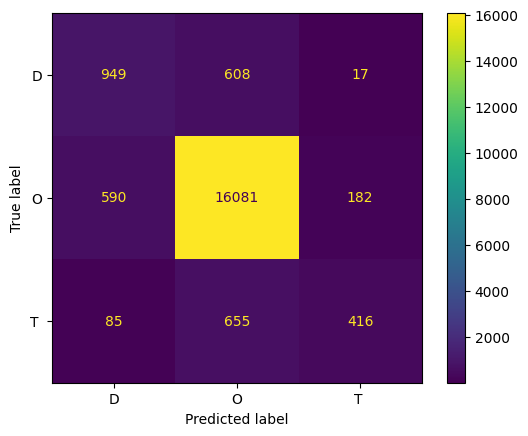

In [ ]:
confusion_matrix_ = confusion_matrix(test_labels, svc_obj.predict(test_data), labels= classes)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_, display_labels = ['D', 'O', 'T '])
cm_display.plot()
plt.show()

### XGBoost Classsifier

In [ ]:
from sklearn.preprocessing import LabelEncoder

# create a LabelEncoder object
le = LabelEncoder()

# fit the LabelEncoder to the data
le.fit(train_labels)

# transform the data
encoded_data = le.transform(train_labels)

In [ ]:
set(encoded_data)

{0, 1, 2}

In [ ]:
# get the feature names
feature_names = le.classes_

# print the feature names
print(feature_names)

['D' 'O' 'T']


In [ ]:
# !pip uninstall xgboost
# !pip install xgboost==1.5.0

In [ ]:
# Create an object the of XGBoost Classifier.
xgb_obj = XGBClassifier(learning_rate= 0.03, max_depth=2, subsample= 0.25, n_estimators= 90, random_state= 42)

In [ ]:
xgb_obj.fit(train_data, train_labels)

In [ ]:
# encoded_test_data = le.transform(test_labels)
# encoded_test_data

In [ ]:
print(classification_report(y_pred= xgb_obj.predict(test_data), y_true= test_labels, labels = classes))

In [ ]:
# Evaluation using cross validation.
cross_val('XGBoost', 'Dict', XGBClassifier(learning_rate= 0.03, max_depth=2, subsample= 0.25, n_estimators= 90, random_state= 42), X= train_data, y= encoded_data, scoring= 'f1_weighted', cv= 5)

#### Predict Single Value

In [ ]:
# Loaded into test dataframe.
y_xgb_test= le.inverse_transform(xgb_obj.predict(test_data))
test_freq_df['label_predicted_xgb'] = get_labels_as_array(y_xgb_test)

In [ ]:
set(test_freq_df['label_predicted_xgb'])

In [ ]:
xgb_disease, xgb_treatment, xgb_sentence, xgb_med_dict = dict_prep(test_freq_df, 'label_predicted_xgb')

In [ ]:
predicted_value('Alex suffers from colon cancer', xgb_obj, xgb_med_dict)

### Voting Classifier

In [ ]:
vote1 = OneVsOneClassifier(SGDClassifier(penalty='l1', random_state=42))
vote2 = OneVsOneClassifier(XGBClassifier(learning_rate= 0.04, max_depth=2, n_estimators= 100, random_state= 42))
vote3 = SVC(kernel='rbf', decision_function_shape= 'ovo')
# Create an object the of Voting Classifier.
voting_model = VotingClassifier(estimators=[('SGD', vote1), ('XGB', vote2), ('RBF', vote3)], voting='hard')

In [ ]:
voting_model.fit(train_data, train_labels)

VotingClassifier(estimators=[('SGD',
                              OneVsOneClassifier(estimator=SGDClassifier(penalty='l1',
                                                                         random_state=42))),
                             ('XGB',
                              OneVsOneClassifier(estimator=XGBClassifier(base_score=None,
                                                                         booster=None,
                                                                         callbacks=None,
                                                                         colsample_bylevel=None,
                                                                         colsample_bynode=None,
                                                                         colsample_bytree=None,
                                                                         device=None,
                                                                         early_stopping_rounds=None,
                                                                         enable_categorical=False,
                                                                         eval_metric=No...
                                                                         interaction_constraints=None,
                                                                         learning_rate=0.04,
                                                                         max_bin=None,
                                                                         max_cat_threshold=None,
                                                                         max_cat_to_onehot=None,
                                                                         max_delta_step=None,
                                                                         max_depth=2,
                                                                         max_leaves=None,
                                                                         min_child_weight=None,
                                                                         missing=nan,
                                                                         monotone_constraints=None,
                                                                         multi_strategy=None,
                                                                         n_estimators=100,
                                                                         n_jobs=None,
                                                                         num_parallel_tree=None,
                                                                         random_state=42, ...))),
                             ('RBF', SVC(decision_function_shape='ovo'))])

In [ ]:
print(classification_report(y_pred= voting_model.predict(test_data), y_true= test_labels, labels = classes))

              precision    recall  f1-score   support

           D       0.75      0.30      0.43      1574
           O       0.89      0.99      0.94     16853
           T       0.78      0.17      0.28      1156

    accuracy                           0.88     19583
   macro avg       0.81      0.49      0.55     19583
weighted avg       0.87      0.88      0.86     19583



In [ ]:
# Evaluation using cross validation.
cross_val('Voting', 'Dict', VotingClassifier(estimators=[('SGD', vote1), ('XGB', vote2), ('RBF', vote3)], voting='hard'), X= train_data, y= train_labels, scoring= 'f1_weighted', cv= 5)


  Voting Classification with Dict Vectorizer Cross Validation Mean Result is: 0.830759256314801
  Voting Classification with Dict Vectorizer Cross Validation Standard Deviation Result is: 0.013268545482573516
  Voting Classification with Dict Vectorizer Cross Validation Score Result is:
[0.83318826 0.84153373 0.845299   0.8258886  0.80788668]


#### Predict Single Value

In [ ]:
# Loaded into test dataframe.
test_freq_df['label_predicted_voting'] = get_labels_as_array(voting_model.predict(test_data))

In [ ]:
voting_disease, voting_treatment, voting_sentence, voting_med_dict = dict_prep(test_freq_df, 'label_predicted_voting')

In [ ]:
predicted_value(input_sent, voting_model, voting_med_dict)

Identified Disease   : cancer
Identified Treatment : chemotherapy, chemotherapy


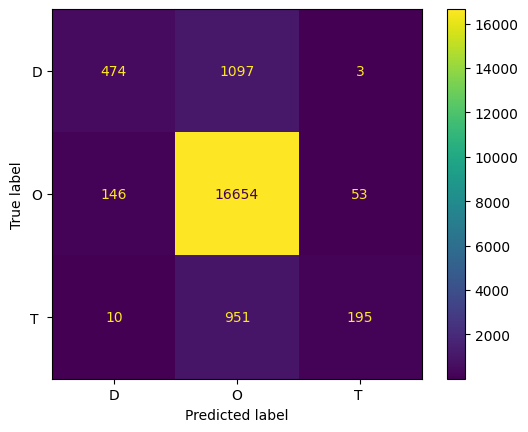

In [ ]:
confusion_matrix_ = confusion_matrix(test_labels, voting_model.predict(test_data), labels= classes)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_, display_labels = ['D', 'O', 'T '])
cm_display.plot()
plt.show()

### Gradient Boosting

In [ ]:
gb_obj = OneVsOneClassifier(GradientBoostingClassifier(learning_rate= 0.07, max_depth= 2, subsample= 0.25, n_estimators= 60, random_state= 42))

In [ ]:
gb_obj.fit(train_data, train_labels)

OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.07,
                                                        max_depth=2,
                                                        n_estimators=60,
                                                        random_state=42,
                                                        subsample=0.25))

In [ ]:
print(classification_report(y_pred= gb_obj.predict(test_data), y_true= test_labels, labels = classes))

              precision    recall  f1-score   support

           D       0.82      0.03      0.06      1574
           O       0.87      1.00      0.93     16853
           T       0.77      0.05      0.10      1156

    accuracy                           0.86     19583
   macro avg       0.82      0.36      0.36     19583
weighted avg       0.86      0.86      0.81     19583



In [ ]:
# Evaluation using cross validation.
cross_val('GradientBoosting', 'Dict', OneVsOneClassifier(GradientBoostingClassifier(learning_rate= 0.07, max_depth= 2, subsample= 0.25, n_estimators= 60, random_state= 42)), X= train_data, y= train_labels, scoring= 'f1_weighted', cv= 5)


  GradientBoosting Classification with Dict Vectorizer Cross Validation Mean Result is: 0.8004907688389556
  GradientBoosting Classification with Dict Vectorizer Cross Validation Standard Deviation Result is: 0.0020626111868640024
  GradientBoosting Classification with Dict Vectorizer Cross Validation Score Result is:
[0.79993599 0.79844021 0.80431286 0.79904257 0.80072222]


#### Predict Single Value

In [ ]:
# Loaded into test dataframe.
test_freq_df['label_predicted_gb'] = get_labels_as_array(gb_obj.predict(test_data))

In [ ]:
gb_disease, gb_treatment, gb_sentence, gb_med_dict = dict_prep(test_freq_df, 'label_predicted_gb')

In [ ]:
predicted_value(input_sent, gb_obj, gb_med_dict)

Identified Disease   : cancer
Identified Treatment : chemotherapy, chemotherapy


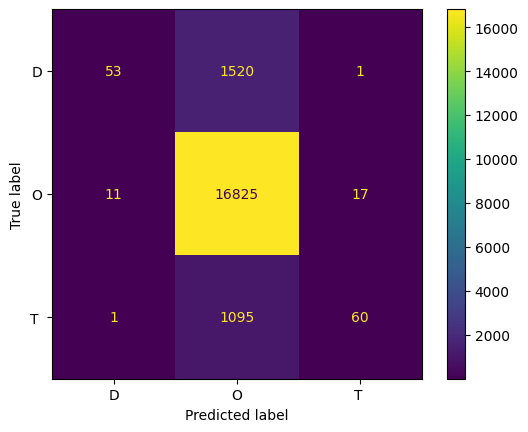

In [ ]:
confusion_matrix_ = confusion_matrix(test_labels, gb_obj.predict(test_data), labels= classes)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_, display_labels = ['D', 'O', 'T '])
cm_display.plot()
plt.show()

### Logistic Regression

In [ ]:
# Create an object the of Logistic Regression.
lg_obj = LogisticRegression(C=0.5, max_iter=500, random_state=42)

In [ ]:
lg_obj.fit(train_data, train_labels)

LogisticRegression(C=0.5, max_iter=500, random_state=42)

In [ ]:
print(classification_report(y_pred= lg_obj.predict(test_data), y_true= test_labels, labels = classes))

              precision    recall  f1-score   support

           D       0.78      0.36      0.49      1574
           O       0.89      0.99      0.94     16853
           T       0.77      0.16      0.26      1156

    accuracy                           0.89     19583
   macro avg       0.81      0.50      0.56     19583
weighted avg       0.88      0.89      0.86     19583



In [ ]:
# Evaluation using cross validation.
cross_val('Logistic Regression', 'Dict', LogisticRegression(max_iter= 500, multi_class='multinomial', random_state=42), X= train_data, y= train_labels, scoring= 'f1_weighted', cv= 5)


  Logistic Regression Classification with Dict Vectorizer Cross Validation Mean Result is: 0.8134583013771932
  Logistic Regression Classification with Dict Vectorizer Cross Validation Standard Deviation Result is: 0.019153698678353825
  Logistic Regression Classification with Dict Vectorizer Cross Validation Score Result is:
[0.82667105 0.82615571 0.83109766 0.80261726 0.78074982]


#### Predict Single Value

In [ ]:
# Loaded into test dataframe.
test_freq_df['label_predicted_lg'] = get_labels_as_array(lg_obj.predict(test_data))

In [ ]:
lg_disease, lg_treatment, lg_sentence, lg_med_dict = dict_prep(test_freq_df, 'label_predicted_gb')

In [ ]:
predicted_value(input_sent, lg_obj, lg_med_dict)

Identified Disease   : cancer
Identified Treatment : chemotherapy, chemotherapy


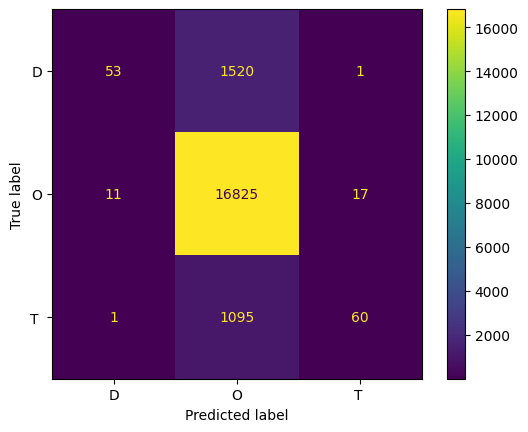

In [ ]:
confusion_matrix_ = confusion_matrix(test_labels, lg_obj.predict(test_data), labels= classes)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_, display_labels = ['D', 'O', 'T '])
cm_display.plot()
plt.show()

### Ridge Classifier

In [ ]:
ridge_obj = RidgeClassifier()

In [ ]:
ridge_obj.fit(train_data, train_labels)

RidgeClassifier()

In [ ]:
print(classification_report(y_pred= ridge_obj.predict(test_data), y_true= test_labels, labels = classes))

              precision    recall  f1-score   support

           D       0.73      0.51      0.60      1574
           O       0.92      0.97      0.94     16853
           T       0.70      0.32      0.44      1156

    accuracy                           0.90     19583
   macro avg       0.78      0.60      0.66     19583
weighted avg       0.89      0.90      0.89     19583



In [ ]:
# Evaluation using cross validation.
cross_val('Ridge', 'Dict', RidgeClassifier(), X= train_data, y= train_labels, scoring= 'f1_weighted', cv= 5)


  Ridge Classification with Dict Vectorizer Cross Validation Mean Result is: 0.7720397609637002
  Ridge Classification with Dict Vectorizer Cross Validation Standard Deviation Result is: 0.08672474326887028
  Ridge Classification with Dict Vectorizer Cross Validation Score Result is:
[0.85525878 0.80501683 0.82791272 0.76238373 0.60962675]


#### Predict Single Value

In [ ]:
# Loaded into test dataframe.
test_freq_df['label_predicted_rg'] = get_labels_as_array(ridge_obj.predict(test_data))

In [ ]:
rg_disease, rg_treatment, rg_sentence, rg_med_dict = dict_prep(test_freq_df, 'label_predicted_rg')

In [ ]:
predicted_value(input_sent, ridge_obj, rg_med_dict)

Identified Disease   : cancer
Identified Treatment : metalloproteinase, metalloproteinase


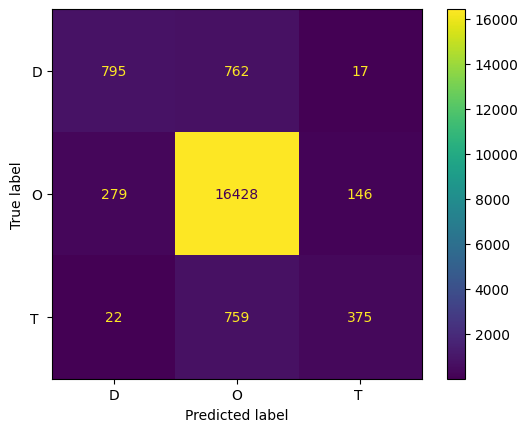

In [ ]:
confusion_matrix_ = confusion_matrix(test_labels, ridge_obj.predict(test_data), labels= classes)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_, display_labels = ['D', 'O', 'T '])
cm_display.plot()
plt.show()

# Parameters Choosing

## Halving Grid Search CV

**Note:** This is an iterative step and I will loop over a specific range of values depends on elimination values recursively.

### Logistic Reggression Classifier Grid Search

In [ ]:
# Define grid search
param_grid = {'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
              'penalty' : ['l2','l1'],
              'C' : [0.01, 0.1, 0.5, 1.0, 5.0, 10]}

search = HalvingGridSearchCV(LogisticRegression(max_iter = 500, random_state = 42), param_grid, resource='n_samples', max_resources= 'auto', random_state=42).fit(train_data, train_labels)
# Summarize results
print("Best: %f using %s" % (search.best_score_, search.best_params_))
means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']
params = search.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self

Best: 0.850452 using {'C': 0.5, 'penalty': 'l2', 'solver': 'lbfgs'}
0.877871 (0.008234) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.877871 (0.008234) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
0.877871 (0.008234) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
nan (nan) with: {'C': 0.01, 'penalty': 'l1', 'solver': 'newton-cg'}
nan (nan) with: {'C': 0.01, 'penalty': 'l1', 'solver': 'lbfgs'}
0.877871 (0.008234) with: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
0.877871 (0.008234) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.877871 (0.008234) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.877871 (0.008234) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
nan (nan) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'newton-cg'}
nan (nan) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'lbfgs'}
0.877871 (0.008234) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.882353 (0.010481) with: {'C': 0.5, 'penalty': 'l2', 'sol

In [ ]:
best_model_lr = search.best_estimator_
best_model_lr

LogisticRegression(C=0.5, max_iter=500, random_state=42)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
lr_train_score_halving = f1_score(train_labels, best_model_lr.predict(train_data), average= "weighted")
lr_test_score_halving = f1_score(test_labels, best_model_lr.predict(test_data), average= "weighted")
display(lr_train_score_halving)
display(lr_test_score_halving)

0.9335380938607882

0.8626651201999499

In [ ]:
# Evaluation using cross validation.
cross_val('Logistic Reggression', 'Dict', best_model_lr, X= train_data, y= train_labels, scoring= 'f1_weighted', cv= 5)


  Logistic Reggression Classification with Dict Vectorizer Cross Validation Mean Result is: 0.8194920645406454
  Logistic Reggression Classification with Dict Vectorizer Cross Validation Standard Deviation Result is: 0.011977865070997667
  Logistic Reggression Classification with Dict Vectorizer Cross Validation Score Result is:
[0.82309097 0.82814888 0.8342026  0.81098207 0.8010358 ]


In [ ]:
predicted_value(input_sent, best_model_lr, rg_med_dict)

Identified Disease   : cancer
Identified Treatment : metalloproteinase, metalloproteinase


### Ridge Classifier Grid Search

In [ ]:
# Ridge classifier object
model = RidgeClassifier()

param_grid = {'alpha' : np.arange(0, 1, 0.1),
              'solver' : ['lbfgs', 'sparse_cg', 'saga'],
              'max_iter' : [100, 500]
}

search = HalvingGridSearchCV(model, param_grid, resource='n_samples', max_resources= 'auto', random_state=42).fit(train_data, train_labels)
# Summarize results
print("Best: %f using %s" % (search.best_score_, search.best_params_))
means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']
params = search.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py", line 1424, in fit
    super().fit(X, Y, sample_weight=sample_weight)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py", line 825, in fit
    raise ValueError(
ValueError: 'lbfgs' solver can be used only

Best: 0.755870 using {'alpha': 0.9, 'max_iter': 100, 'solver': 'sparse_cg'}
nan (nan) with: {'alpha': 0.0, 'max_iter': 100, 'solver': 'lbfgs'}
0.324930 (0.115547) with: {'alpha': 0.0, 'max_iter': 100, 'solver': 'sparse_cg'}
nan (nan) with: {'alpha': 0.0, 'max_iter': 100, 'solver': 'saga'}
nan (nan) with: {'alpha': 0.0, 'max_iter': 500, 'solver': 'lbfgs'}
0.324930 (0.115547) with: {'alpha': 0.0, 'max_iter': 500, 'solver': 'sparse_cg'}
nan (nan) with: {'alpha': 0.0, 'max_iter': 500, 'solver': 'saga'}
nan (nan) with: {'alpha': 0.1, 'max_iter': 100, 'solver': 'lbfgs'}
0.862185 (0.025697) with: {'alpha': 0.1, 'max_iter': 100, 'solver': 'sparse_cg'}
nan (nan) with: {'alpha': 0.1, 'max_iter': 100, 'solver': 'saga'}
nan (nan) with: {'alpha': 0.1, 'max_iter': 500, 'solver': 'lbfgs'}
0.862185 (0.025697) with: {'alpha': 0.1, 'max_iter': 500, 'solver': 'sparse_cg'}
nan (nan) with: {'alpha': 0.1, 'max_iter': 500, 'solver': 'saga'}
nan (nan) with: {'alpha': 0.2, 'max_iter': 100, 'solver': 'lbfgs'}
0

In [ ]:
best_model_rc = search.best_estimator_
best_model_rc

RidgeClassifier(alpha=0.9, max_iter=100, solver='sparse_cg')

In [ ]:
rc_train_score_halving = f1_score(train_labels, best_model_rc.predict(train_data), average= "weighted")
rc_test_score_halving = f1_score(test_labels, best_model_rc.predict(test_data), average= "weighted")
display(rc_train_score_halving)
display(rc_test_score_halving)

0.9497688082712867

0.886615208646622

In [ ]:
# Evaluation using cross validation.
cross_val('Ridge', 'Dict', best_model_rc, X= train_data, y= train_labels, scoring= 'f1_weighted', cv= 5)


  Ridge Classification with Dict Vectorizer Cross Validation Mean Result is: 0.7687532203969085
  Ridge Classification with Dict Vectorizer Cross Validation Standard Deviation Result is: 0.08922057929510342
  Ridge Classification with Dict Vectorizer Cross Validation Score Result is:
[0.85577789 0.80050216 0.82619245 0.75937267 0.60192094]


In [ ]:
predicted_value(input_sent, best_model_rc, rg_med_dict)

Identified Disease   : cancer
Identified Treatment : metalloproteinase, metalloproteinase


### Multinomial NB

In [ ]:
grid_params ={'alpha':[10**x for x in range(-4,4)]}
param_grid = {
              'alpha' : [math.log(x,10) for x in grid_params["alpha"]]
}

search = HalvingGridSearchCV(MultinomialNB(), param_grid, resource='n_samples', max_resources= 'auto', random_state=42).fit(train_data, train_labels)
# Summarize results
print("Best: %f using %s" % (search.best_score_, search.best_params_))
means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']
params = search.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default val

Best: 0.816406 using {'alpha': 2.9999999999999996}
nan (nan) with: {'alpha': -3.999999999999999}
nan (nan) with: {'alpha': -2.9999999999999996}
nan (nan) with: {'alpha': -1.9999999999999996}
nan (nan) with: {'alpha': -0.9999999999999998}
0.571065 (0.055328) with: {'alpha': 0.0}
0.811549 (0.019034) with: {'alpha': 1.0}
0.864514 (0.002394) with: {'alpha': 2.0}
0.864762 (0.001086) with: {'alpha': 2.9999999999999996}
0.701184 (0.046337) with: {'alpha': 1.0}
0.763658 (0.040750) with: {'alpha': 2.0}
0.816406 (0.022250) with: {'alpha': 2.9999999999999996}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.57106489 0.81154921
 0.86451413 0.8647625  0.70118431 0.76365845 0.81640618]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan        nan 0.97240416 0.94210771
 0.89051684 0.86912929 0.94700869 0.94013841 0.91940852]
  warnings.warn(


In [ ]:
best_model_nb = search.best_estimator_
best_model_nb

MultinomialNB(alpha=2.9999999999999996)

In [ ]:
nb_train_score_halving = f1_score(train_labels, best_model_nb.predict(train_data), average= "weighted")
nb_test_score_halving = f1_score(test_labels, best_model_nb.predict(test_data), average= "weighted")
display(nb_train_score_halving)
display(nb_test_score_halving)

0.9123892054970028

0.8704743146094972

In [ ]:
# Evaluation using cross validation.
cross_val('Multinomial NB', 'Dict', best_model_nb, X= train_data, y= train_labels, scoring= 'f1_weighted', cv= 5)


  Multinomial NB Classification with Dict Vectorizer Cross Validation Mean Result is: 0.7990843342281255
  Multinomial NB Classification with Dict Vectorizer Cross Validation Standard Deviation Result is: 0.02278103075809563
  Multinomial NB Classification with Dict Vectorizer Cross Validation Score Result is:
[0.81534534 0.79866078 0.78685019 0.76431215 0.8302532 ]


In [ ]:
predicted_value(input_sent, best_model_nb, nb_med_dict)

Identified Disease   : cancer
Identified Treatment : metalloproteinase inhibitors treatment, metalloproteinase inhibitors treatment


### SGD Grid Search

In [ ]:
alpha = [10**x for x in range(-4,4)]
penalty = ["l1","l2"]
params ={'alpha':alpha,'penalty':penalty}
alpha_log = [math.log(x,10) for x in params["alpha"]]

In [ ]:
search = HalvingGridSearchCV(SGDClassifier(), params, resource='n_samples', max_resources= 'auto', random_state=42).fit(train_data, train_labels)
# Summarize results
print("Best: %f using %s" % (search.best_score_, search.best_params_))
means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']
params = search.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

Best: 0.864256 using {'alpha': 0.001, 'penalty': 'l2'}
0.826095 (0.056550) with: {'alpha': 0.0001, 'penalty': 'l1'}
0.842311 (0.039047) with: {'alpha': 0.0001, 'penalty': 'l2'}
0.868034 (0.006606) with: {'alpha': 0.001, 'penalty': 'l1'}
0.875303 (0.007784) with: {'alpha': 0.001, 'penalty': 'l2'}
0.864306 (0.004846) with: {'alpha': 0.01, 'penalty': 'l1'}
0.864306 (0.004846) with: {'alpha': 0.01, 'penalty': 'l2'}
0.864306 (0.004846) with: {'alpha': 0.1, 'penalty': 'l1'}
0.864306 (0.004846) with: {'alpha': 0.1, 'penalty': 'l2'}
0.864306 (0.004846) with: {'alpha': 1, 'penalty': 'l1'}
0.864306 (0.004846) with: {'alpha': 1, 'penalty': 'l2'}
0.864306 (0.004846) with: {'alpha': 10, 'penalty': 'l1'}
0.864306 (0.004846) with: {'alpha': 10, 'penalty': 'l2'}
0.864306 (0.004846) with: {'alpha': 100, 'penalty': 'l1'}
0.864306 (0.004846) with: {'alpha': 100, 'penalty': 'l2'}
0.864306 (0.004846) with: {'alpha': 1000, 'penalty': 'l1'}
0.702144 (0.323147) with: {'alpha': 1000, 'penalty': 'l2'}
0.864762 

In [ ]:
best_model_sgd = search.best_estimator_
best_model_sgd

SGDClassifier(alpha=0.001)

In [ ]:
sgd_train_score_halving = f1_score(train_labels, pd.Series(best_model_sgd.predict(train_data)), average= "weighted")
sgd_test_score_halving = f1_score(test_labels, best_model_sgd.predict(test_data), average= "weighted")
display(sgd_train_score_halving)
display(sgd_test_score_halving)

0.8228166178723879

0.8214336217046059

**Compute Croos validation of the best performance**

In [ ]:
# Evaluation using cross validation.
cross_val('SGD', 'Dict', best_model_sgd, X= train_data, y= train_labels, scoring= 'f1_weighted', cv= 5)


  SGD Classification with Dict Vectorizer Cross Validation Mean Result is: 0.8122302138564192
  SGD Classification with Dict Vectorizer Cross Validation Standard Deviation Result is: 0.0029122715605149506
  SGD Classification with Dict Vectorizer Cross Validation Score Result is:
[0.81014914 0.81004068 0.81645709 0.80947591 0.81502825]


In [ ]:
predicted_value(input_sent, best_model_sgd, sgd_med_dict)

Identified Disease   : cancer
Identified Treatment : chemotherapy, chemotherapy
